In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
datapath = "../data/data/v2.0/"
import csv
from collections import defaultdict
import seaborn as sn
from numpy.random import default_rng
from sklearn import tree
import decisiontree as dt

In [2]:
maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

In [3]:
english_dataframe = pd.read_csv(datapath+"hipe2020/en/HIPE-2022-v2.0-hipe2020-dev-en.tsv", sep = '\t', header = 0, engine="python", comment='#', quoting=csv.QUOTE_NONE)

In [4]:
# combine_sign = "¬"
# del_list = []
# english_dataframe = english_dataframe.copy()
# for i in range(len(english_dataframe)):
#     if english_dataframe.loc[i]["MISC"] == "NoSpaceAfter" and english_dataframe.loc[i+1]["TOKEN"] == combine_sign and english_dataframe.loc[i+1]["MISC"] == "EndOfLine":
#         new_token = english_dataframe.loc[i]["TOKEN"] + english_dataframe.loc[i+2]["TOKEN"]
#         english_dataframe.at[i,"TOKEN"] = new_token
#         del_list += [i+1, i+2]

In [5]:
# english_dataframe.drop(index = del_list, inplace=True)
# english_dataframe.reset_index(drop=True, inplace=True)

In [6]:
misc_list = english_dataframe["MISC"].to_list()

In [7]:
sentence_idx = []
idx = 0
for item in misc_list:
    sentence_idx.append(idx)
    if "EndOfSentence" in item:
        idx += 1
english_dataframe["SENTENCE_ID"] = sentence_idx

In [8]:
labelled_sentences = set()
for i, label in enumerate(english_dataframe["NE-COARSE-LIT"].to_list()):
    if label != "O":
        labelled_sentences.add(sentence_idx[i])

In [9]:
token_dict = english_dataframe["TOKEN"].str.lower().value_counts().to_dict()

In [10]:
NE_dict = english_dataframe[english_dataframe["NE-COARSE-LIT"] != "O"]["TOKEN"].value_counts().to_dict()

In [11]:
feature_list = []
total_word_count = len(english_dataframe)
total = 0
for key in token_dict:
    total += token_dict[key]
    feature_list.append(key)
    if total > total_word_count * 0.5:
        break
print(total)
print(feature_list)
print(len(feature_list))

14543
[',', 'the', '.', 'of', 'and', 'to', 'a', '¬', 'in', 'is', '-', 'that', 'for', 'he', 'be', 'as', 'was', 'it', 'at', 'on', 'by', 'with', 'this', 'will', 'have', 'from', '’', 'his', 'are', 'i', 'their', ';', 'which', 's', 'not', 'they', 'has', '*', "'", '“', 'you', 'an', 'or', 'one', 'all', '”', 'we', 'been', 'but', 'no', 'who', 'than', 'our', 'were', 'other', 'them', '—', 'any', 'county', 'when', 'made', 'man', 'new', 'more', 'can', 'j', 'out', 'there', 'may', 'would', 'day', 'its', ':', 'had', 'men']
75


In [12]:
post_fix_dict_3 = defaultdict(lambda:0)
post_fix_dict_2 = defaultdict(lambda:0)
post_fix_3_list = []
post_fix_2_list = []
for key in token_dict:
    if key == "endofsentence":
        continue
    if len(key) <= 2:
        continue
    count = token_dict[key]
    
    if len(key) == 3:
        post_fix_2 = key[-2:]
        post_fix_dict_2[post_fix_2] += count
        if post_fix_dict_2[post_fix_2] >= 30 and post_fix_2 not in post_fix_2_list:
            post_fix_2_list.append(post_fix_2)
        continue

    post_fix_3 = key[-3:]
    post_fix_dict_3[post_fix_3] += count
    if post_fix_dict_3[post_fix_3] >= 30 and post_fix_3 not in post_fix_3_list:
            post_fix_3_list.append(post_fix_3)
    

In [13]:
label_list =  list(pd.unique(english_dataframe["NE-COARSE-LIT"]))

In [14]:
feature_matrix = []
label_matrix = []
pos_dict = defaultdict(lambda: [])
label_dict = defaultdict(lambda: [])
pos = 0
progress = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
prev_label = 0
extra_features = 6
check = True
for idx in english_dataframe.index:
    if idx/len(english_dataframe) > progress[0]:
        print(progress[0])
        progress.pop(0)
    pos += 1
    row = english_dataframe.iloc[idx]
    token = row["TOKEN"]
    if isinstance(token, float): #null in the tsv is taken as a nan value
        token = "null"
    prev_label = label
    label = int(row["NE-COARSE-LIT"] != "O")
    if token.lower() in feature_list:
        pos_dict[token.lower() ].append(pos)
    if "EndOfSentence" not in row["MISC"]:
        label_dict[token].append((pos,label,prev_label,0))
        continue
    label_dict[token].append((pos,label,prev_label,1))
    # loop of all tokens in a sentence
    for token in label_dict:
        # loop over all ocurances of a token
        for item in label_dict[token]:
            feature_vector = np.full(shape = (len(feature_list)+extra_features), fill_value = np.inf) #differntiate between wheter a token occurs or wheter the current token is in the top 50%
            # label_vector = np.zeros(shape=(2))
            current_pos = item[0]
            
            # loop over all features present in a sentence
            for feature in pos_dict:
                closest_pos = pos_dict[feature][0] - current_pos # starting point
                
                # loop over all occurences of a feature present in a sentence
                for pos in pos_dict[feature]:
                    relative_pos = pos - current_pos
                    if abs(relative_pos) < abs(closest_pos):
                        closest_pos = relative_pos
                    else: break
                feature_vector[feature_list.index(feature)] = closest_pos
            feature_vector[-1] = item[0] # add location as feature
            feature_vector[-2] = item[3] # add wheter the item is the end of a sentence
            feature_vector[-3] = int(token[0].isupper()) #add wheter the first char is a capital letter
            feature_vector[-4] = int(any(char.isdigit() for char in token)) #add wheter the token contains a number
            

            # add post fixes
            if len(token) > 3:
                post_fix = token[-3:].lower()
                if post_fix in post_fix_3_list:
                    feature_vector[-5] = post_fix_3_list.index(post_fix) + 1
                    check = False
                # print(post_fix)
                else: 
                    feature_vector[-5] = 0
            if len(token) > 2:
                post_fix = token[-2:].lower()
                if post_fix in post_fix_2_list:
                    feature_vector[-6] = post_fix_2_list.index(post_fix) + 1
                else: 
                    feature_vector[-6] = 0
                # print(post_fix)
            # if not check:
            #     print(token)
            #     break
            feature_matrix.append(feature_vector)
            # label_vector[item[1]] = 1
            label_matrix.append(item[1])
    # break
    pos = 0
    pos_dict = defaultdict(lambda: [])
    label_dict = defaultdict(lambda: [])
    prev_label = 0
feature_matrix = np.array(feature_matrix)
label_matrix = np.array(label_matrix)


0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [17]:
total_features = training_feature_matrix.shape[1]
discrete_idx_list = [total_features-2, total_features-3, total_features-4, total_features-5, total_features-6]

In [ ]:
total_sentences = len(set(sentence_idx))
split = 0.9
rng = default_rng()
training_sentence_ids = rng.choice(total_sentences, size=int(total_sentences*split), replace=False)
test_sentence_ids = [i for i in range(total_sentences) if i not in training_sentence_ids]

training_id_list = []
test_id_list = []
for i, item in enumerate(sentence_idx):
    if item in training_sentence_ids:
        training_id_list.append(i)
    else:
        test_id_list.append(i)

training_feature_matrix = np.array([feature_matrix[i] for i in training_id_list])
training_label_matrix = np.array([label_matrix[i] for i in training_id_list])
test_feature_matrix = np.array([feature_matrix[i] for i in test_id_list])
test_label_matrix = np.array([label_matrix[i] for i in test_id_list])

In [ ]:
print(training_feature_matrix.shape)

In [ ]:
print(discrete_idx_list)

In [ ]:
test_classifier = dt.custom_decision_tree(training_feature_matrix, training_label_matrix, discrete_idx_list=discrete_idx_list, min_samples=35, print_progress=True)
test_classifier.build_tree()

In [ ]:
test_classifier = dt.custom_decision_tree(training_feature_matrix, training_label_matrix, discrete_idx_list=discrete_idx_list, min_samples=35, method="gini")
test_classifier.build_tree()

In [ ]:
custom_tree = test_classifier.tree

In [ ]:
custom_tree.print_node()

In [ ]:
tp = 0
fp = 0
fn = 0
tn = 0
total = 0
prediction = custom_tree.predict_matrix(test_feature_matrix)
print("prediction complete")
prev_label = 0
for i, pred in enumerate(prediction):
    correct_label = test_label_matrix[i]
    if correct_label == 0 and pred == 0:
        tn += 1
    elif correct_label == 0 and pred != 0:
        fn += 1
    elif correct_label == 1 and pred == 0:
        fn += 1
    else:
        tp += 1

accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp/(tp+fn)
precision = tp/(tp+fp)
f_1 = (2*precision*recall)/(precision+recall)
print(f"accuracy: {accuracy}")
print(f"recall: {recall}")
print(f"precision: {precision}" )
print(f"f_1: {f_1}")

In [ ]:
# print(sentence_idx)
# print(test_id_list)

In [ ]:
np.where(np.array(sentence_idx)==6)[0]

In [ ]:
# print(sentence_idx)

In [ ]:
test_dict = defaultdict(lambda: {"tp": 0, "fp": 0, "tn": 0, "fn": 0})
wrong_pred_dict = defaultdict(lambda:[])
correct_pred_dict = defaultdict(lambda:[])
for i, pred in enumerate(prediction):
    id = test_id_list[i]
    sentence_id = sentence_idx[id]
    label = english_dataframe.iloc[id]["NE-COARSE-LIT"]
    token = english_dataframe.iloc[id]["TOKEN"]
    if label == "O" and pred == 0:
        test_dict["O"]["tp"] += 1
    elif label == "O" and pred == 1:
        test_dict["O"]["fn"] += 1
    elif label != "O" and pred == 0:
        test_dict[label]["fn"] += 1
        test_dict["O"]["fp"] += 1
        wrong_pred_dict[sentence_id].append((id,label,token))
    elif label != "O" and pred == 1:
        test_dict[label]["tp"] += 1
        test_dict["O"]["tn"] += 1
        correct_pred_dict[sentence_id].append((id,label,token))

In [ ]:
import os
# C:\Users\karst\OneDrive\Documenten\uni\jaar 3 semester 2, het semester dat ik opgaf\Bachelor-graduation-project\code\results\pred_sentence.txt

In [ ]:
# code\results\pred_sentence.txt
# return_file = os.path.join("code", "results", "pred_sentence.txt")
return_file = "C:/Users/karst/OneDrive/Documenten/uni/jaar 3 semester 2, het semester dat ik opgaf/Bachelor-graduation-project/code/results/pred_sentence.txt"

with open(return_file, "w") as f:
    pass

for sentence_id in test_id_list:
    if sentence_id not in correct_pred_dict and sentence_id not in wrong_pred_dict:
        continue
    sentence = ""
    token_idx_list = np.where(np.array(sentence_idx)==sentence_id)[0]
    wrong_idx_dict = dict()
    
    if sentence_id in wrong_pred_dict:
        for wrong_pred in wrong_pred_dict[sentence_id]:
            wrong_idx_dict[wrong_pred[0]] = wrong_pred[1]
    correct_idx_dict = dict()
    if sentence_id in correct_pred_dict:
        for correct_pred in correct_pred_dict[sentence_id]:
            correct_idx_dict[correct_pred[0]] = correct_pred[1]
    
    
    for idx in token_idx_list:
        token = english_dataframe.iloc[idx]["TOKEN"]
        if idx in wrong_idx_dict:
            token += f" (WRONG, label: {wrong_idx_dict[idx]}) "
        elif idx in correct_idx_dict:
            token += f" (CORRECT, label: {correct_idx_dict[idx]}) "
        sentence += token  + " "
    with open(return_file, "a") as f:
        f.write(str(sentence_id) + "\n" + sentence + "\n" + "-" * 69 +"\n")

In [ ]:
for key in test_dict:
    if key == "O":
        continue
    print(key)
    temp_tp = test_dict[key]['tp']
    temp_fn = test_dict[key]["fn"]
    print(temp_tp/(temp_tp+temp_fn))
    print("------------------------")

In [ ]:
print(set(sentence_idx))

In [18]:
test_itterations = 5
prob_itterations = 10
performance_dict = defaultdict(lambda:{"avg_prec":[], "avg_recall": [], "avg_acc": [], "avg_f1":[]})
recall_dict =  defaultdict(lambda: defaultdict(lambda:[]))

for test_itter in range(test_itterations):
    total_sentences = len(set(sentence_idx))
    rng = default_rng()
    training_sentence_ids = rng.choice(total_sentences, size=int(total_sentences*0.5), replace=False)
    training_count = len(training_sentence_ids)
    test_sentence_ids = [i for i in range(total_sentences) if i not in training_sentence_ids]
    test_id_list = []
    for i, item in enumerate(sentence_idx):
        if item in test_sentence_ids:
            test_id_list.append(i)

    
    test_feature_matrix = np.array([feature_matrix[i] for i in test_id_list])
    test_label_matrix = np.array([label_matrix[i] for i in test_id_list])
    for prob in np.arange(0.2, 1.2, step=0.2):
        for prob_itter in range(prob_itterations):
            training_id_list = []
            if prob == 1:
                current_training_sentence_ids = training_sentence_ids.copy()
            else:
                current_training_sentence_ids = rng.choice(training_sentence_ids, size=int(training_count*prob), replace=False)
            for i, item in enumerate(sentence_idx):
                if item in current_training_sentence_ids:
                    training_id_list.append(i)
            training_feature_matrix = np.array([feature_matrix[i] for i in training_id_list])
            training_label_matrix = np.array([label_matrix[i] for i in training_id_list])
            print(f"test itter {test_itter}, prob itter: {prob_itter}, prob: {prob*0.5}")
            test_classifier = dt.custom_decision_tree(training_feature_matrix, training_label_matrix, discrete_idx_list=discrete_idx_list, min_samples=35, print_progress=False)
            test_classifier.build_tree()

            custom_tree = test_classifier.tree
            
            tp = 0
            fp = 0
            fn = 0
            tn = 0
            total = 0
            prediction = custom_tree.predict_matrix(test_feature_matrix)
            prev_label = 0
            temp_dict = defaultdict(lambda: {"tp": 0, "fp": 0, "tn": 0, "fn": 0})
            for i, pred in enumerate(prediction):
                correct_label = test_label_matrix[i]
                id = test_id_list[i]
                label_txt = english_dataframe.iloc[id]["NE-COARSE-LIT"]
                if correct_label == 0 and pred == 0:
                    tn += 1
                elif correct_label == 0 and pred != 0:
                    fn += 1
                elif correct_label == 1 and pred == 0:
                    fn += 1
                else:
                    tp += 1
                
                if label_txt == "O" and pred == 0:
                    temp_dict["O"]["tp"] += 1
                elif label_txt == "O" and pred == 1:
                    temp_dict["O"]["fn"] += 1
                elif label_txt != "O" and pred == 0:
                    temp_dict[label_txt]["fn"] += 1
                    temp_dict["O"]["fp"] += 1
                elif label_txt != "O" and pred == 1:
                    temp_dict[label_txt]["tp"] += 1
                    temp_dict["O"]["tn"] += 1
            
            if tp == 0:
                precision = 0
                recall = 0
                f_1 = 0
            else:
                precision = tp/(tp+fp)
                recall = tp/(tp+fn)
                f_1 = (2*precision*recall)/(precision+recall)
            accuracy = (tp + tn) / (tp + tn + fp + fn)
            performance_dict[prob]["avg_prec"].append(precision)
            performance_dict[prob]["avg_recall"].append(recall)
            performance_dict[prob]["avg_acc"].append(accuracy)
            performance_dict[prob]["avg_f1"].append(f_1)

            for key in temp_dict:
                tp = temp_dict[key]["tp"]
                fn = temp_dict[key]["fn"]
                if tp == 0:
                    recall = 0
                else:
                    recall = tp/(tp+fn)
                recall_dict[prob][key].append(recall)

test itter 0, prob itter: 0, prob: 0.1
test itter 0, prob itter: 1, prob: 0.1
test itter 0, prob itter: 2, prob: 0.1
test itter 0, prob itter: 3, prob: 0.1
test itter 0, prob itter: 4, prob: 0.1
test itter 0, prob itter: 5, prob: 0.1
test itter 0, prob itter: 6, prob: 0.1
test itter 0, prob itter: 7, prob: 0.1
test itter 0, prob itter: 8, prob: 0.1
test itter 0, prob itter: 9, prob: 0.1
test itter 0, prob itter: 0, prob: 0.2
test itter 0, prob itter: 1, prob: 0.2
test itter 0, prob itter: 2, prob: 0.2
test itter 0, prob itter: 3, prob: 0.2
test itter 0, prob itter: 4, prob: 0.2
test itter 0, prob itter: 5, prob: 0.2
test itter 0, prob itter: 6, prob: 0.2
test itter 0, prob itter: 7, prob: 0.2
test itter 0, prob itter: 8, prob: 0.2
test itter 0, prob itter: 9, prob: 0.2
test itter 0, prob itter: 0, prob: 0.30000000000000004
test itter 0, prob itter: 1, prob: 0.30000000000000004
test itter 0, prob itter: 2, prob: 0.30000000000000004
test itter 0, prob itter: 3, prob: 0.30000000000000004


In [19]:
for key in recall_dict:
    recall_dict[key] = dict(recall_dict[key])

In [20]:
import pickle
map_path = "C:/Users/karst/OneDrive/Documenten/uni/jaar 3 semester 2, het semester dat ik opgaf/Bachelor-graduation-project/code/notebooks/"
with open(map_path + 'performance_dict_0.5.pkl', 'wb') as outp:
    pickle.dump(dict(performance_dict), outp)
with open(map_path + 'recall_dict_0.5.pkl', 'wb') as outp:
    pickle.dump(dict(recall_dict), outp)

In [ ]:
for key in performance_dict:
    print(key)
    for category in performance_dict[key]:
        print(f"{category}: {np.mean(performance_dict[key][category])}")
    print("----------------")

In [ ]:
import matplotlib.pyplot as plt


In [22]:
temp_plot_list = []

for key in performance_dict:
    temp_plot_list.append(performance_dict[key]["avg_recall"])

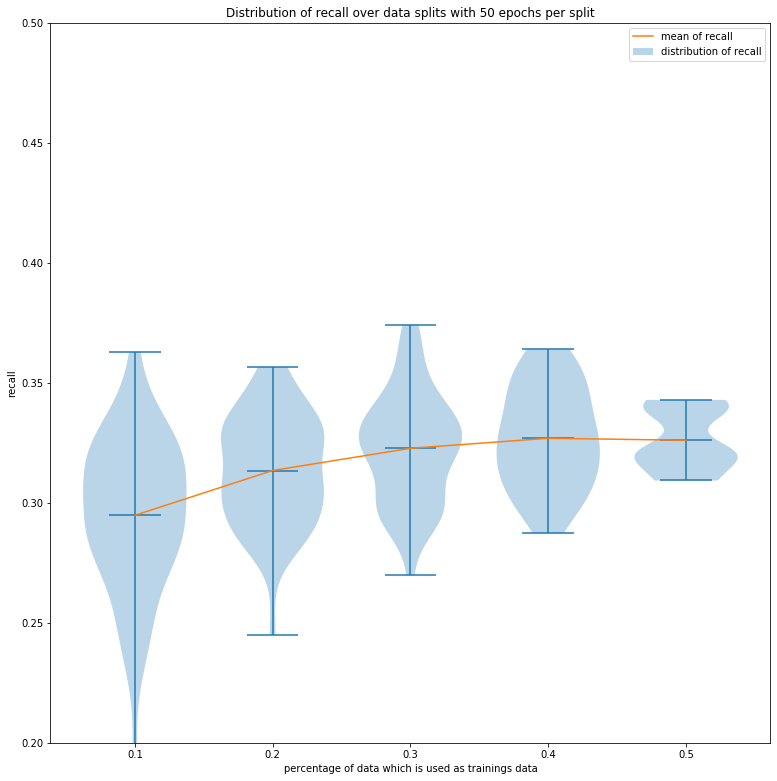

In [23]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
labels = [i/10 for i in range(1,6)]
ax.violinplot(temp_plot_list, showmeans=True, widths=0.75)
ax.plot([1,2,3,4,5],np.mean(temp_plot_list, axis=1))
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(labels)
ax.set_ylim(0.2,0.5)
ax.set_xlabel(xlabel="percentage of data which is used as trainings data")
ax.set_ylabel(ylabel="recall")
ax.legend(["mean of recall","distribution of recall"])
ax.set_title("Distribution of recall over data splits with 50 epochs per split")
plt.show()

In [ ]:
np.random.seed(10)
collectn_1 = np.random.normal(100, 10, 200)
collectn_2 = np.random.normal(80, 30, 200)
collectn_3 = np.random.normal(90, 20, 200)
collectn_4 = np.random.normal(70, 25, 200)

## combine these different collections into a list
data_to_plot = [collectn_1, collectn_2, collectn_3, collectn_4]

In [ ]:
for key in recall_dict:
    print(key)
    for category in recall_dict[key]:
        print(f"{category}: {np.mean(recall_dict[key][category])}")
        print("-"*69)


In [ ]:
with open('performance_dict_2.pkl', 'wb') as outp:
    pickle.dump(performance_dict, outp)
with open('recall_dict.pkl_2', 'wb') as outp:
    pickle.dump(recall_dict, outp)

In [ ]:
data_to_plot